In [2]:
!gdown --fuzzy "https://drive.google.com/file/d/1JHBClArVdM-Cr1b8In1iakTV_TvC3HvG/view?usp=drive_link"

Downloading...
From (uriginal): https://drive.google.com/uc?id=1JHBClArVdM-Cr1b8In1iakTV_TvC3HvG
From (redirected): https://drive.google.com/uc?id=1JHBClArVdM-Cr1b8In1iakTV_TvC3HvG&confirm=t&uuid=9622f366-e651-40a5-8aaa-b8920ffc08d9
To: /nfs/datab/hungdx/SSL_Anti-spoofing/Best_LA_model_for_DF.pth
100%|██████████████████████████████████████| 1.27G/1.27G [06:10<00:00, 3.44MB/s]


In [2]:
from model import Model

In [3]:
model = Model(None, device=device)

In [ ]:
model.eval()

In [5]:
# Load audio
import librosa
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import torch
import torchaudio
import librosa.display

def load_audio(path):
    audio, sample_rate = torchaudio.load(path)
    return audio, sample_rate

audio, sample_rate = load_audio('./common_voice_en_1164.wav')


In [6]:
result = model(audio)

In [7]:
result

tensor([[ 0.1645, -0.2066]], grad_fn=<AddmmBackward>)

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

def target_category_loss(x, category_index, nb_classes):
    return torch.mul(x, F.one_hot(category_index, nb_classes))

def target_category_loss_output_shape(input_shape):
    return input_shape


def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (torch.sqrt(torch.mean(torch.square(x))) + 1e-5)

def resize_1d(array, shape):
    res = np.zeros(shape)
    if array.shape[0] >= shape:
        ratio = array.shape[0]/shape
        for i in range(array.shape[0]):
            res[int(i/ratio)] += array[i]*(1-(i/ratio-int(i/ratio)))
            if int(i/ratio) != shape-1:
                res[int(i/ratio)+1] += array[i]*(i/ratio-int(i/ratio))
            else:
                res[int(i/ratio)] += array[i]*(i/ratio-int(i/ratio))
        res = res[::-1]
        array = array[::-1]
        for i in range(array.shape[0]):
            res[int(i/ratio)] += array[i]*(1-(i/ratio-int(i/ratio)))
            if int(i/ratio) != shape-1:
                res[int(i/ratio)+1] += array[i]*(i/ratio-int(i/ratio))
            else:
                res[int(i/ratio)] += array[i]*(i/ratio-int(i/ratio))
        res = res[::-1]/(2*ratio)
        array = array[::-1]
    else:
        ratio = shape/array.shape[0]
        left = 0
        right = 1
        for i in range(shape):
            if left < int(i/ratio):
                left += 1
                right += 1
            if right > array.shape[0]-1:
                res[i] += array[left]
            else:
                res[i] += array[right] * \
                    (i - left * ratio)/ratio+array[left]*(right*ratio-i)/ratio
        res = res[::-1]
        array = array[::-1]
        left = 0
        right = 1
        for i in range(shape):
            if left < int(i/ratio):
                left += 1
                right += 1
            if right > array.shape[0]-1:
                res[i] += array[left]
            else:
                res[i] += array[right] * \
                    (i - left * ratio)/ratio+array[left]*(right*ratio-i)/ratio
        res = res[::-1]/2
        array = array[::-1]
    return res


class ActivationsAndGradients:
    """ Class for extracting activations and
    registering gradients from targeted intermediate layers """

    def __init__(self, model, target_layer):
        self.model = model
        self.gradients = []
        self.activations = []

        self.target_layer = target_layer

    def __enter__(self):
        # Register the hooks when entering the context
        self.forward_hook_handle = self.target_layer.register_forward_hook(self.save_activation)
        self.backward_hook_handle = self.target_layer.register_full_backward_hook(self.save_gradient)
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        # Unregister the hooks when exiting the context
        self.forward_hook_handle.remove()
        self.backward_hook_handle.remove()

    def save_activation(self, module, input, output):
        self.activations.append(output.detach())

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = [grad_output[0].detach()] + self.gradients

    def __call__(self, x):
        self.gradients.clear()
        self.activations.clear()
        return self.model(x)


class BaseCAM:
    def __init__(self, model, target_layer, device=None):
        self.model = model.eval()
        self.target_layer = target_layer
        self.device = device
        if self.device is not None:
            self.model = model.to(device)

    def forward(self, input_img):
        return self.model(input_img)

    def get_cam_weights(self, input_tensor, target_category, activations, grads):
        raise Exception("Not Implemented. Please Implement in the child class")

    def get_loss(self, output, target_category):
        return output[target_category]

    def __call__(self, input_tensor, target_category=None):
        if self.device is not None:
            input_tensor = input_tensor.to(self.device)

        with ActivationsAndGradients(model, self.target_layer) as aag:
            output = aag(input_tensor)

            if target_category is None:
                output = output.squeeze()
                print(output.shape)
                # target_category = torch.tensor([np.argmax(output.cpu().data.numpy())], dtype=torch.float, requires_grad=True).long()
                target_category = torch.tensor([np.argmax(output.cpu().data.numpy())], dtype=torch.long)
                print(target_category.dtype)
                
                print(target_category)

            self.model.zero_grad()
            loss = self.get_loss(output, target_category)
            loss.backward(retain_graph=True)

            activations = aag.activations[-1].cpu().data.numpy()[0, :]
            grads = aag.gradients[-1].cpu().data.numpy()[0, :]

            weights = self.get_cam_weights(input_tensor, target_category, activations, grads)

            cam = np.sum(activations * weights[:, None], axis=0)

            print('CAM shape: ', cam.shape)
            if cam.ndim == 1:
                # Handle 1D CAM
                cam = np.interp(np.linspace(0, cam.shape[0], input_tensor.shape[-1]), np.linspace(0, cam.shape[0], cam.shape[0]), cam)

            else:
                raise ValueError("Unsupported CAM shape")

            cam = np.interp(np.linspace(0, cam.shape[0], input_tensor.shape[-1]), np.linspace(0, cam.shape[0], cam.shape[0]), cam)

            heatmap = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))
        
            return heatmap


    
class AudioGradCAM(BaseCAM):
    def __init__(self, model, target_layer, device=None):
        super(AudioGradCAM, self).__init__(model, target_layer, device)

    def get_cam_weights(self, input_tensor,
                        target_category,
                        activations,
                        grads):
        grads_power_2 = grads ** 2
        grads_power_3 = grads_power_2 * grads
        sum_activations = np.sum(activations, axis=1)
        eps = 0.000001
        aij = grads_power_2 / (2 * grads_power_2 + sum_activations[:, None] * grads_power_3 + eps)
        aij = np.where(grads != 0, aij, 0)

        weights = np.maximum(grads, 0) * aij
        weights = np.sum(weights, axis=1)
        return weights
  

In [9]:
device = 'cuda:1'
target_layer = model.ssl_model.model.feature_extractor.conv_layers[6][0]
heatmap = AudioGradCAM(model, target_layer, device)(audio)

torch.Size([2])
torch.int64
tensor([0])
CAM shape:  (1045,)


In [ ]:
model.eval()

In [11]:
model.ssl_model.model.encoder.pos_conv[0]

Conv1d(1024, 1024, kernel_size=(128,), stride=(1,), padding=(64,), groups=16)

In [14]:
target_layer = model.pool_hT2.proj
device = 'cuda:2'
heatmap2 = AudioGradCAM(model, target_layer, device)(audio)

torch.Size([2])
torch.int64
tensor([0])
CAM shape:  (1,)


/home/hungdx/miniconda3/envs/SSL_Spoofing/lib/python3.7/site-packages/ipykernel_launcher.py:156: RuntimeWarning: invalid value encountered in true_divide


In [18]:
heatmap

array([0.08407853, 0.08407853, 0.08407853, ..., 0.86260402, 0.86275446,
       0.86290489])

In [19]:
heatmap.shape

(334704,)

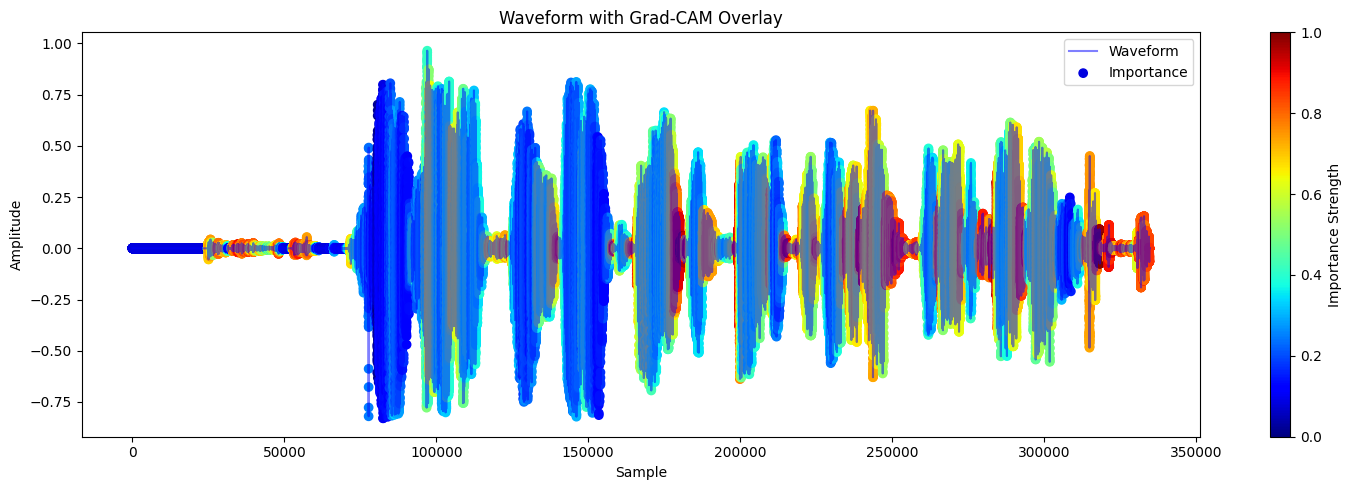

In [16]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def visualize_heatmap_and_waveform(heatmap, waveform, start_idx=0):
    # Assuming waveform is a PyTorch tensor; convert it to numpy array
    waveform = waveform.squeeze().cpu().numpy()
    
    # Check if the lengths are different; if so, interpolate heatmap

    # upsample_heatmap = np.interp(np.linspace(0, len(waveform), len(waveform)),
    #                         np.linspace(0, len(heatmap), len(heatmap)),
    #                         heatmap)
    
    plt.figure(figsize=(15, 5))
    x_values = np.arange(start_idx, start_idx + len(waveform))
    plt.plot(x_values, waveform, label='Waveform', color='blue', alpha=0.5)
    plt.scatter(x_values, waveform, c=heatmap, cmap=cm.jet, label='Importance')
    plt.title('Waveform with Grad-CAM Overlay')
    plt.xlabel('Sample')
    plt.ylabel('Amplitude')
    cbar = plt.colorbar()
    cbar.set_label('Importance Strength')
    plt.legend()
    plt.tight_layout()
    plt.show()

# Assuming heatmap and waveform variables are already defined and ready
# If transform(waveform.to(device)) results in a transformed waveform, 
# assign its result to a variable before passing it to the visualization function.

visualize_heatmap_and_waveform(heatmap, audio)


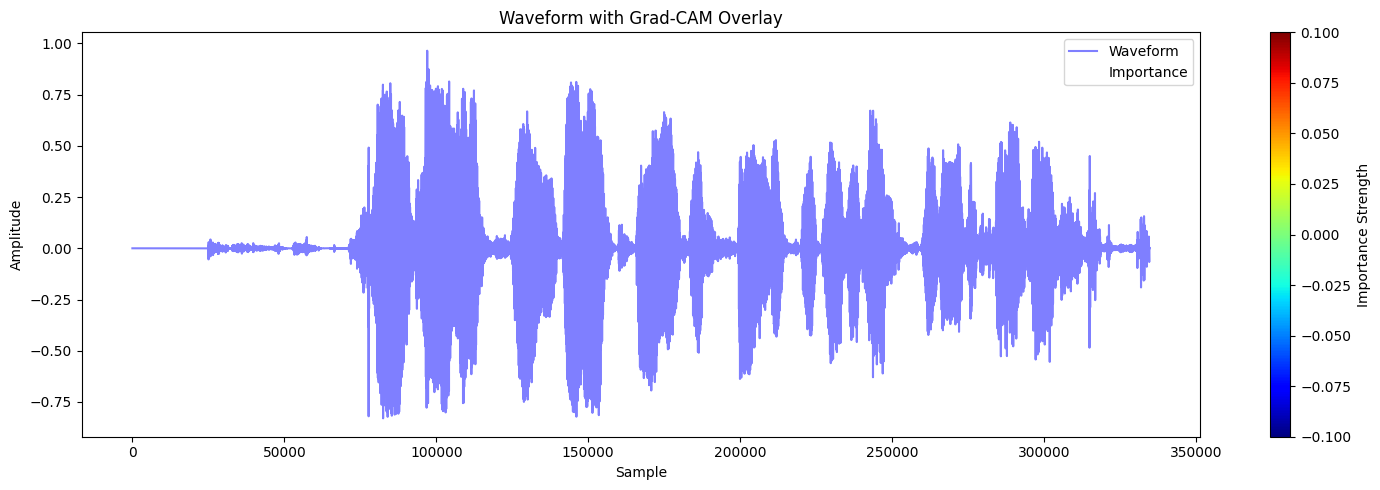

In [17]:
visualize_heatmap_and_waveform(heatmap2, audio)

In [ ]:
target_layer = model.GAT_layer_S.bn
device = 'cuda:0'
heatmap2 = AudioGradCAM(model, target_layer, device)(audio)

torch.Size([2])
torch.int64
tensor([0])


/home/hungdx/miniconda3/envs/SSL_Spoofing/lib/python3.7/site-packages/torch/nn/functional.py:1321: UserWarning: Output 0 of ViewBackward is a view and is being modified inplace. This view was created inside a custom Function (or because an input was returned as-is) and the autograd logic to handle view+inplace would override the custom backward associated with the custom Function, leading to incorrect gradients. This behavior is deprecated and will be forbidden starting version 1.6. You can remove this warning by cloning the output of the custom Function. (Triggered internally at  /pytorch/torch/csrc/autograd/variable.cpp:547.)
  result = torch.selu_(input)


RuntimeError: Module backward hook for grad_input is called before the grad_output one. This happens because the gradient in your nn.Module flows to the Module's input without passing through the Module's output. Make sure that the output depends on the input and that the loss is computed based on the output.

torch.Size([2])
torch.int64
tensor([1])


/home/hungdx/miniconda3/envs/SSL_Spoofing/lib/python3.7/site-packages/torch/nn/functional.py:1321: UserWarning: Output 0 of ViewBackward is a view and is being modified inplace. This view was created inside a custom Function (or because an input was returned as-is) and the autograd logic to handle view+inplace would override the custom backward associated with the custom Function, leading to incorrect gradients. This behavior is deprecated and will be forbidden starting version 1.6. You can remove this warning by cloning the output of the custom Function. (Triggered internally at  /pytorch/torch/csrc/autograd/variable.cpp:547.)
  result = torch.selu_(input)


RuntimeError: Module backward hook for grad_input is called before the grad_output one. This happens because the gradient in your nn.Module flows to the Module's input without passing through the Module's output. Make sure that the output depends on the input and that the loss is computed based on the output.